✓ Project root found: c:\Users\Tennie Mum\Desktop\repos\Plant-Disease-Detection
✓ Working directory: c:\Users\Tennie Mum\Desktop\repos\Plant-Disease-Detection
✓ All imports successful!

[1/4] Merging raw images...
Merging images from data/raw → data/merged...
  ✓ Merged 87900 images
[2/4] Cleaning corrupt images and building manifest...
Cleaning images from data/merged...
  Apple___Apple_scab: 2520 images
  Apple___Black_rot: 2484 images
  Apple___Cedar_apple_rust: 2200 images
  Apple___healthy: 2510 images
  Blueberry___healthy: 2270 images
  Cherry_(including_sour)___Powdery_mildew: 2104 images
  Cherry_(including_sour)___healthy: 2282 images
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 2052 images
  Corn_(maize)___Common_rust_: 2384 images
  Corn_(maize)___Northern_Leaf_Blight: 2385 images
  Corn_(maize)___healthy: 2324 images
  Grape___Black_rot: 2360 images
  Grape___Esca_(Black_Measles): 2400 images
  Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 2152 images
  Grape___heal

c:\Users\Tennie Mum\Desktop\repos\Plant-Disease-Detection\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


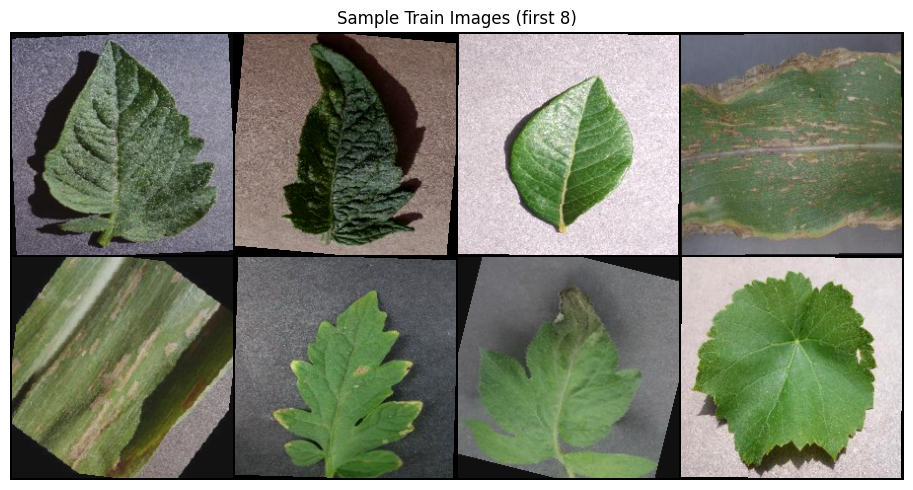


Exporting class names for team...

  ✓ class_names.json saved (39 classes)

  Disease Classes (39 total):
     0: Apple___Apple_scab
     1: Apple___Black_rot
     2: Apple___Cedar_apple_rust
     3: Apple___healthy
     4: Blueberry___healthy
     5: Cherry_(including_sour)___Powdery_mildew
     6: Cherry_(including_sour)___healthy
     7: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
     8: Corn_(maize)___Common_rust_
     9: Corn_(maize)___Northern_Leaf_Blight
    10: Corn_(maize)___healthy
    11: Grape___Black_rot
    12: Grape___Esca_(Black_Measles)
    13: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
    14: Grape___healthy
    15: Orange___Haunglongbing_(Citrus_greening)
    16: Peach___Bacterial_spot
    17: Peach___healthy
    18: Pepper,_bell___Bacterial_spot
    19: Pepper,_bell___healthy
    20: Potato___Early_blight
    21: Potato___Late_blight
    22: Potato___healthy
    23: Raspberry___healthy
    24: Soybean___healthy
    25: Squash___Powdery_mildew
    26: Straw

In [ ]:
import sys
from pathlib import Path

notebook_dir = Path.cwd()
project_root = None

# Just trying multiple ways to find project root
for candidate in [notebook_dir.parent, notebook_dir.parent.parent, Path.home() / "Desktop" / "repos" / "Plant-Disease-Detection"]:
    if (candidate / "src").is_dir() and (candidate / "data").is_dir():
        project_root = candidate
        break

if project_root is None:
    raise RuntimeError(f"Could not find project root from {notebook_dir}. Expected to find 'src' and 'data' directories.")

# Add to path and change directory
sys.path.insert(0, str(project_root))
import os
os.chdir(project_root)

print(f"✓ Project root found: {project_root}")
print(f"✓ Working directory: {os.getcwd()}")


import src
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import json

from src.preprocess_data import merge_all_images, clean_and_list_images, stratified_split, save_split
from src.data_interface import get_dataloaders, PlantDataset, get_transforms

print("✓ All imports successful!\n")


# Step 1: We are going to cover Merging , Cleaning, Stratified Split of the dataset

print("[1/4] Merging raw images...")
merge_all_images()

print("[2/4] Cleaning corrupt images and building manifest...")
images, labels = clean_and_list_images()
print(f"    Total images found: {len(images)}")
print(f"    Unique classes: {len(set(labels))}")

print("[3/4] Creating stratified train/val/test split...")
train_split, val_split, test_split = stratified_split(images, labels)
print(f"    Train: {len(train_split[0])} | Val: {len(val_split[0])} | Test: {len(test_split[0])}")

print("[4/4] Saving splits to data/processed/...")
save_split(train_split, "train")
save_split(val_split, "val")
save_split(test_split, "test")


# Step 2: Generating the CSV Manifests

def save_csv(split, name):
    imgs, labels = split
    df = pd.DataFrame({"filepath": imgs, "label": labels})
    os.makedirs("data/processed", exist_ok=True)
    df.to_csv(f"data/processed/{name}.csv", index=False)
    print(f"  ✓ {name}.csv → {len(df)} rows")

print("\nGenerating CSV manifests...")
save_csv(train_split, "train")
save_csv(val_split, "val")
save_csv(test_split, "test")


# Step 3: Create PyTorch DataLoader(Only the training data is augmented , the others are just resized )

print("\nInitializing DataLoaders (batch_size=32, img_size=224)...")
batch_size = 32
img_size = 224
train_loader, val_loader, test_loader = get_dataloaders(batch_size=batch_size, img_size=img_size)
#Validation check
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


# Step 4: Visualize Sample Batch

print("\nVisualizing sample batch...")
images, labels = next(iter(train_loader))
grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(10, 5))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Sample Train Images (first 8)")
plt.axis("off")
plt.tight_layout()
plt.show()


# Step 5: Export class names for the team; save as json and csv file

print("\nExporting class names for team...")

# Load dataset to get class names
transform_train, _ = get_transforms()
train_dataset = PlantDataset("data/processed/train", transform=transform_train)
class_names = train_dataset.classes


class_mapping = {idx: name for idx, name in enumerate(class_names)}


os.makedirs("data", exist_ok=True)
with open("data/class_names.json", "w") as f:
    json.dump(class_mapping, f, indent=2)

print(f"\n  ✓ class_names.json saved ({len(class_names)} classes)")
print(f"\n  Disease Classes ({len(class_names)} total):")
for idx, name in enumerate(class_names):
    print(f"    {idx:2d}: {name}")


class_df = pd.DataFrame({
    "class_index": list(range(len(class_names))),
    "disease_name": class_names
})
class_df.to_csv("data/class_names.csv", index=False)
print(f"\n  ✓ class_names.csv saved")

print("\n✓ Data pipeline complete! Ready for model training.")
print(f"✓ Team can use class names from: data/class_names.json or data/class_names.csv")
